In [1]:
import datetime
import numpy as np
import os
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import albumentations as A


from math import log2
from PIL import Image
from pydicom import dcmread
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from tqdm import tqdm
from torchvision.utils import save_image

In [2]:
torch.cuda.empty_cache()

In [3]:
%run utils.ipynb

## Utils

In [4]:
from torchvision.utils import save_image
from scipy.stats import truncnorm

# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, cur_res, lr, tensorboard_step
):
    writer.add_scalar("data/loss_dis", loss_critic, global_step=tensorboard_step)
    writer.add_scalar("data/loss_gen", loss_gen, global_step=tensorboard_step)
    writer.add_scalar("data/cur_resl", int(cur_res), global_step=tensorboard_step)
    writer.add_scalar("data/cur_lr", lr, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:16], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, steps, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, Z_DIM, 1, 1)), device=DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

## Model

In [5]:
"""
Implementation of ProGAN generator and discriminator with the key
attributions from the paper. We have tried to make the implementation
compact but a goal is also to keep it readable and understandable.
Specifically the key points implemented are:

1) Progressive growing (of model and layers)
2) Minibatch std on Discriminator
3) Normalization with PixelNorm
4) Equalized Learning Rate (here I cheated and only did it on Conv layers)
"""

"""
Factors is used in Discrmininator and Generator for how much
the channels should be multiplied and expanded for each layer,
so specifically the first 5 layers the channels stay the same,
whereas when we increase the img_size (towards the later layers)
we decrease the number of chanels by 1/2, 1/4, etc.
"""
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)


# if __name__ == "__main__":
#     Z_DIM = 100
#     IN_CHANNELS = 256
#     gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)
#     critic = Discriminator(Z_DIM, IN_CHANNELS, img_channels=3)

#     for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
#         num_steps = int(log2(img_size / 4))
#         x = torch.randn((1, Z_DIM, 1, 1))
#         z = gen(x, 0.5, steps=num_steps)
#         assert z.shape == (1, 3, img_size, img_size)
#         out = critic(z, alpha=0.5, steps=num_steps)
#         assert out.shape == (1, 1)
#         print(f"Success! At img size: {img_size}")

## Hyperparameters

In [6]:
LUNG_CANCER_TYPE = 'adeno'
EPOCHS = [50]
LEARNING_RATE = 1e-3
# MODEL_NAME = f'pggan_roi_{LUNG_CANCER_TYPE}_epochs_{EPOCHS[0]}_lr_{LEARNING_RATE}'
MODEL_NAME = f'pggan_roi_{LUNG_CANCER_TYPE}_prog_epochs_alpha_0.75'
CHECKPOINT_GEN = f"models/gan/generator_{MODEL_NAME}.pth.tar"
CHECKPOINT_CRITIC = f"models/gan/critic_{MODEL_NAME}.pth.tar"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_MODEL = True
LOAD_MODEL = False
LEARNING_RATE_DECAY = None
BATCH_SIZES = [32, 32, 32, 32, 32] # 4, 8, 16, 32, 64, 128, 256, 512 # [32, 32, 32, 24, 12]
START_TRAIN_AT_IMG_SIZE = 4
MAX_RES = 64
CHANNELS_IMG = 1
Z_DIM = 512  # should be 512 in original paper
IN_CHANNELS = 512  # should be 512 in original paper
CRITIC_ITERATIONS = 1
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = EPOCHS * len(BATCH_SIZES)
# PROGRESSIVE_EPOCHS = [30,30,30,50,75]
FIXED_NOISE = torch.randn(16, Z_DIM, 1, 1).to(DEVICE)
NUM_WORKERS = 4
TRAIN_DIR = f"/Storage/PauloOctavioDir/nodule_rois/gan/{LUNG_CANCER_TYPE}/images"
MIN_HU_VALUE = -1024
MAX_HU_VALUE = 1000
ALPHA_MUL = 0.75

## Dataset and Loader

In [7]:
def normalize(image):
    min_val = MIN_HU_VALUE
    max_val = MAX_HU_VALUE
    image[image < min_val] = min_val
    image[image > max_val] = max_val
    image = (image - min_val) / (max_val - min_val)
    return image

def denormalize(image):
    min_val = MIN_HU_VALUE
    max_val = MAX_HU_VALUE
    return image * (max_val - min_val) + min_val

In [8]:
class LungNoduleDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        images = os.listdir(image_dir)
        if 'rtss.dcm' in images: images.remove('rtss.dcm')
        self.images = images


    def __len__(self):
         return len(self.images)


    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        data = dcmread(img_path)
        image = np.array(data.pixel_array).astype('float32')
        # Conversio to HU
        intercept = int(data.RescaleIntercept)
        slope = int(data.RescaleSlope)
        image = (slope * image) + intercept
        image = normalize(image)
        return self.transform(image)

In [9]:
""" Training of ProGAN using WGAN-GP loss"""

torch.backends.cudnn.benchmarks = True

class RandomRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=.5),
#             transforms.RandomApply([transforms.CenterCrop(int(image_size * .9))], p=.3),
#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(1,2))], p=.3),
#             transforms.Resize((image_size, image_size)),
            RandomRotationTransform(angles=[90,270, 0, 0, 0]),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )

    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = LungNoduleDataset(image_dir=TRAIN_DIR, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset

Dataset Size: 3263
Number of batches: 102


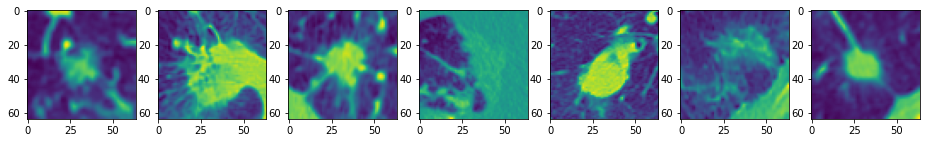

In [10]:
loader, dataset = get_loader(64)
indexes = random.sample(range(0, len(dataset)), 7)

# print(f'Index: {idx}')
# print(f"Shape: {image.shape} \nMin: {image.min()} \nMax: {image.max()}")
print(f"Dataset Size: {len(dataset)}")
print(f"Number of batches: {len(loader)}")
fig, ax = plt.subplots(1,7, figsize=(16,6))
for i in range(7):
    image = dataset[indexes[i]][0].cpu().detach().numpy()
    ax[i].imshow(image)
plt.show()

## Training

In [11]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
    lr,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, real in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        cur_res = real.shape[2]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * ALPHA_MUL) * len(dataset)
        )
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE, alpha, step) * 0.5 + 0.5

            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                cur_res,
                lr,
                tensorboard_step,
            )
            tensorboard_step += 1
        if tensorboard_step % 15 == 0:  
            img_grid_fake = torchvision.utils.make_grid(fixed_fakes.detach()[:16], normalize=True)
            save_image(img_grid_fake.float(), f'gan_fakes/{MODEL_NAME}/step_{step}_{tensorboard_step}_grid.png')

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha


def main():
    gen = Generator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)
    critic = Discriminator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)
    
    # initialize optimizers and scalers for FP16 training
    lr=LEARNING_RATE
    opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.99))
    opt_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.99))
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()
    os.makedirs(os.path.dirname(f"gan_fakes/{MODEL_NAME}/"), exist_ok=True)

    # for tensorboard plotting
    writer = SummaryWriter(f"logs/{MODEL_NAME}")
    print(f"Model name: {MODEL_NAME}")

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, lr,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC, critic, opt_critic, lr,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    # start at step that corresponds to img size that we set in config
    step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
    start = time.time()
    global_epoch = 0
    print('Started training...')
    for num_epochs in PROGRESSIVE_EPOCHS[step:int(log2(MAX_RES / 2))]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64->4, ...

        for epoch in range(num_epochs):
            epoch_start = time.time()
            tensorboard_step, alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                tensorboard_step,
                writer,
                scaler_gen,
                scaler_critic,
                lr,
            )
            global_epoch += 1
            epoch_end = time.time()
            training_time = str(datetime.timedelta(seconds= epoch_end - epoch_start))
            print(f"Epoch [{epoch+1}/{num_epochs}] Global Epoch:{global_epoch} - Epoch training time: {training_time} - Current image size: {4 * 2 ** step} ")
        step += 1  # progress to the next img size
        # Update learning rate
        if LEARNING_RATE_DECAY:
            lr *= float(LEARNING_RATE_DECAY)
            opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.99))
            opt_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.99))
        if SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC)
    end = time.time()
    training_time = str(datetime.timedelta(seconds= end - start))
    print(f"Trainig duration: {training_time}")
    return training_time

In [ ]:
## df = pd.DataFrame(columns=['model', 'alpha_mul', 'seed', 'epochs', 'hist_type', 'lr','aug', 'bs'])
# df.to_csv('gan_logging.csv', index=False)

# Treinamento do modelo com bons resultados para tipo escamoso
columns=['model', 'alpha_mul', 'seed', 'epochs', 'hist_type', 'lr','aug', 'bs', 'training_time']

ALPHA_MUL = 0.75
SEED = 42

seed_everything(seed=SEED)
for LUNG_CANCER_TYPE in ['squamous']:
    for BATCH_SIZES in [[64, 64, 64, 32, 32]]:
        for PROGRESSIVE_EPOCHS in [[30, 30, 50, 50, 75]]:
            print(f'Training for {LUNG_CANCER_TYPE}')
            bs_str = '_'.join(map(str, BATCH_SIZES))
            pg_epochs = '_'.join(map(str, PROGRESSIVE_EPOCHS))
            MODEL_NAME = f'pggan_roi_{LUNG_CANCER_TYPE}_epochs_{pg_epochs}_alpha_{ALPHA_MUL}_bs_{bs_str}_affn_trns_only'
            CHECKPOINT_GEN = f"generator_{MODEL_NAME}.pth.tar"
            CHECKPOINT_CRITIC = f"critic_{MODEL_NAME}.pth.tar"
            TRAIN_DIR = f"/Storage/PauloOctavioDir/nodule_rois/gan/{LUNG_CANCER_TYPE}/images"
            START_TRAIN_AT_IMG_SIZE = 4
            training_time = main()
            df_data = [
                MODEL_NAME, str(ALPHA_MUL), str(SEED), str(pg_epochs),
                LUNG_CANCER_TYPE, str(LEARNING_RATE), 'only_affine',
                BATCH_SIZES, training_time
            ]
            for col, val in zip(columns, df_data):
                print(f"{col}: {val}")
            df = pd.read_csv('gan_logging.csv')
            df.loc[len(df)] = df_data
            df.to_csv('gan_logging.csv', index=False)

Training for squamous
Model name: pggan_roi_squamous_epochs_30_30_50_50_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only
Started training...


100%|██████████| 67/67 [00:02<00:00, 28.80it/s, gp=0.08, loss_critic=-.991]  


Epoch [1/30] Global Epoch:1 - Epoch training time: 0:00:02.328034 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.79it/s, gp=0.0292, loss_critic=-.467]


Epoch [2/30] Global Epoch:2 - Epoch training time: 0:00:02.178135 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.91it/s, gp=0.0171, loss_critic=-.355]


Epoch [3/30] Global Epoch:3 - Epoch training time: 0:00:02.241909 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 28.33it/s, gp=0.0176, loss_critic=-.112] 


Epoch [4/30] Global Epoch:4 - Epoch training time: 0:00:02.366845 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.28it/s, gp=0.0273, loss_critic=0.111]  


Epoch [5/30] Global Epoch:5 - Epoch training time: 0:00:02.214879 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 31.27it/s, gp=0.0185, loss_critic=0.0106] 


Epoch [6/30] Global Epoch:6 - Epoch training time: 0:00:02.144611 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.17it/s, gp=0.0212, loss_critic=0.094]  


Epoch [7/30] Global Epoch:7 - Epoch training time: 0:00:02.298801 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.19it/s, gp=0.0172, loss_critic=0.0246]  


Epoch [8/30] Global Epoch:8 - Epoch training time: 0:00:02.220987 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.98it/s, gp=0.0192, loss_critic=0.00404]


Epoch [9/30] Global Epoch:9 - Epoch training time: 0:00:02.164690 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.22it/s, gp=0.0148, loss_critic=0.00628]


Epoch [10/30] Global Epoch:10 - Epoch training time: 0:00:02.218849 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.69it/s, gp=0.0333, loss_critic=0.12]   


Epoch [11/30] Global Epoch:11 - Epoch training time: 0:00:02.185166 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.36it/s, gp=0.0188, loss_critic=-.071]  


Epoch [12/30] Global Epoch:12 - Epoch training time: 0:00:02.283916 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.51it/s, gp=0.0153, loss_critic=-.00666] 


Epoch [13/30] Global Epoch:13 - Epoch training time: 0:00:02.272086 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.22it/s, gp=0.0127, loss_critic=0.0111] 


Epoch [14/30] Global Epoch:14 - Epoch training time: 0:00:02.218954 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.66it/s, gp=0.0104, loss_critic=-.0872]  


Epoch [15/30] Global Epoch:15 - Epoch training time: 0:00:02.261684 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.15it/s, gp=0.0164, loss_critic=-.0494] 


Epoch [16/30] Global Epoch:16 - Epoch training time: 0:00:02.224393 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.30it/s, gp=0.0182, loss_critic=-.0438] 


Epoch [17/30] Global Epoch:17 - Epoch training time: 0:00:02.213128 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.04it/s, gp=0.0155, loss_critic=-.0196] 


Epoch [18/30] Global Epoch:18 - Epoch training time: 0:00:02.309267 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 28.95it/s, gp=0.0168, loss_critic=0.00638]


Epoch [19/30] Global Epoch:19 - Epoch training time: 0:00:02.315923 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 28.71it/s, gp=0.0393, loss_critic=0.297]  


Epoch [20/30] Global Epoch:20 - Epoch training time: 0:00:02.335834 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.13it/s, gp=0.00829, loss_critic=-.0066]


Epoch [21/30] Global Epoch:21 - Epoch training time: 0:00:02.225828 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.95it/s, gp=0.00498, loss_critic=-.0315]  


Epoch [22/30] Global Epoch:22 - Epoch training time: 0:00:02.239397 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.72it/s, gp=0.0107, loss_critic=0.034]   


Epoch [23/30] Global Epoch:23 - Epoch training time: 0:00:02.182611 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.52it/s, gp=0.0101, loss_critic=0.0467]  


Epoch [24/30] Global Epoch:24 - Epoch training time: 0:00:02.197056 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.84it/s, gp=0.00629, loss_critic=0.0178] 


Epoch [25/30] Global Epoch:25 - Epoch training time: 0:00:02.174687 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 29.40it/s, gp=0.018, loss_critic=0.157]     


Epoch [26/30] Global Epoch:26 - Epoch training time: 0:00:02.281174 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.67it/s, gp=0.0128, loss_critic=0.173]  


Epoch [27/30] Global Epoch:27 - Epoch training time: 0:00:02.186487 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.69it/s, gp=0.0144, loss_critic=0.103]   


Epoch [28/30] Global Epoch:28 - Epoch training time: 0:00:02.184823 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 30.35it/s, gp=0.0191, loss_critic=0.232]  


Epoch [29/30] Global Epoch:29 - Epoch training time: 0:00:02.209306 - Current image size: 4 


100%|██████████| 67/67 [00:02<00:00, 31.00it/s, gp=0.0143, loss_critic=0.111]  


Epoch [30/30] Global Epoch:30 - Epoch training time: 0:00:02.163429 - Current image size: 4 
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 67/67 [00:05<00:00, 11.80it/s, gp=0.00616, loss_critic=-.158] 


Epoch [1/30] Global Epoch:31 - Epoch training time: 0:00:05.678271 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.76it/s, gp=0.00597, loss_critic=-.253] 


Epoch [2/30] Global Epoch:32 - Epoch training time: 0:00:05.699155 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.78it/s, gp=0.0228, loss_critic=-.0106] 


Epoch [3/30] Global Epoch:33 - Epoch training time: 0:00:05.690387 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.71it/s, gp=0.00649, loss_critic=-.318] 


Epoch [4/30] Global Epoch:34 - Epoch training time: 0:00:05.725989 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.67it/s, gp=0.00554, loss_critic=-.147] 


Epoch [5/30] Global Epoch:35 - Epoch training time: 0:00:05.741233 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.77it/s, gp=0.0105, loss_critic=-.0853]  


Epoch [6/30] Global Epoch:36 - Epoch training time: 0:00:05.692931 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.75it/s, gp=0.0217, loss_critic=0.0443]  


Epoch [7/30] Global Epoch:37 - Epoch training time: 0:00:05.703635 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.77it/s, gp=0.00908, loss_critic=0.017]   


Epoch [8/30] Global Epoch:38 - Epoch training time: 0:00:05.694604 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.73it/s, gp=0.0197, loss_critic=0.0221]  


Epoch [9/30] Global Epoch:39 - Epoch training time: 0:00:05.711835 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.75it/s, gp=0.0123, loss_critic=-.0897]  


Epoch [10/30] Global Epoch:40 - Epoch training time: 0:00:05.705930 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.67it/s, gp=0.00696, loss_critic=0.0721]


Epoch [11/30] Global Epoch:41 - Epoch training time: 0:00:05.742115 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.76it/s, gp=0.0246, loss_critic=0.365]   


Epoch [12/30] Global Epoch:42 - Epoch training time: 0:00:05.700005 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.66it/s, gp=0.0053, loss_critic=-.0539]  


Epoch [13/30] Global Epoch:43 - Epoch training time: 0:00:05.748348 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.78it/s, gp=0.00773, loss_critic=0.133]  


Epoch [14/30] Global Epoch:44 - Epoch training time: 0:00:05.691555 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.63it/s, gp=0.0124, loss_critic=0.0304]  


Epoch [15/30] Global Epoch:45 - Epoch training time: 0:00:05.763044 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.75it/s, gp=0.00808, loss_critic=-.00133]


Epoch [16/30] Global Epoch:46 - Epoch training time: 0:00:05.702299 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.76it/s, gp=0.0124, loss_critic=0.0412]   


Epoch [17/30] Global Epoch:47 - Epoch training time: 0:00:05.700810 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.76it/s, gp=0.00683, loss_critic=-.0498]  


Epoch [18/30] Global Epoch:48 - Epoch training time: 0:00:05.701473 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.80it/s, gp=0.00721, loss_critic=0.008]   


Epoch [19/30] Global Epoch:49 - Epoch training time: 0:00:05.680068 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.73it/s, gp=0.00595, loss_critic=-.0428] 


Epoch [20/30] Global Epoch:50 - Epoch training time: 0:00:05.714987 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.75it/s, gp=0.0136, loss_critic=0.122]    


Epoch [21/30] Global Epoch:51 - Epoch training time: 0:00:05.702732 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.74it/s, gp=0.00652, loss_critic=0.00671]


Epoch [22/30] Global Epoch:52 - Epoch training time: 0:00:05.706813 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.76it/s, gp=0.0129, loss_critic=0.03]     


Epoch [23/30] Global Epoch:53 - Epoch training time: 0:00:05.699539 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.74it/s, gp=0.0114, loss_critic=0.137]   


Epoch [24/30] Global Epoch:54 - Epoch training time: 0:00:05.708884 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.78it/s, gp=0.0104, loss_critic=0.138]    


Epoch [25/30] Global Epoch:55 - Epoch training time: 0:00:05.691362 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.75it/s, gp=0.0124, loss_critic=0.147]    


Epoch [26/30] Global Epoch:56 - Epoch training time: 0:00:05.705559 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.76it/s, gp=0.00745, loss_critic=0.00444]


Epoch [27/30] Global Epoch:57 - Epoch training time: 0:00:05.700789 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.77it/s, gp=0.00517, loss_critic=0.0559] 


Epoch [28/30] Global Epoch:58 - Epoch training time: 0:00:05.695158 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.72it/s, gp=0.00758, loss_critic=0.101]   


Epoch [29/30] Global Epoch:59 - Epoch training time: 0:00:05.717948 - Current image size: 8 


100%|██████████| 67/67 [00:05<00:00, 11.66it/s, gp=0.0144, loss_critic=0.109]   


Epoch [30/30] Global Epoch:60 - Epoch training time: 0:00:05.749369 - Current image size: 8 
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 67/67 [00:18<00:00,  3.63it/s, gp=0.0106, loss_critic=0.139]  


Epoch [1/50] Global Epoch:61 - Epoch training time: 0:00:18.465981 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.62it/s, gp=0.00578, loss_critic=-.166]  


Epoch [2/50] Global Epoch:62 - Epoch training time: 0:00:18.534192 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.0083, loss_critic=-.114]  


Epoch [3/50] Global Epoch:63 - Epoch training time: 0:00:18.556006 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.0129, loss_critic=-.242]   


Epoch [4/50] Global Epoch:64 - Epoch training time: 0:00:18.595191 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.0109, loss_critic=-.0418] 


Epoch [5/50] Global Epoch:65 - Epoch training time: 0:00:18.622851 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.011, loss_critic=-.22]     


Epoch [6/50] Global Epoch:66 - Epoch training time: 0:00:18.626701 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.0122, loss_critic=0.394]   


Epoch [7/50] Global Epoch:67 - Epoch training time: 0:00:18.629194 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00591, loss_critic=-.199]  


Epoch [8/50] Global Epoch:68 - Epoch training time: 0:00:18.616118 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00448, loss_critic=-.191]  


Epoch [9/50] Global Epoch:69 - Epoch training time: 0:00:18.594095 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00711, loss_critic=-.12]   


Epoch [10/50] Global Epoch:70 - Epoch training time: 0:00:18.591790 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00519, loss_critic=0.0536] 


Epoch [11/50] Global Epoch:71 - Epoch training time: 0:00:18.588592 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00784, loss_critic=-.346]  


Epoch [12/50] Global Epoch:72 - Epoch training time: 0:00:18.586827 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.0097, loss_critic=-.0996]  


Epoch [13/50] Global Epoch:73 - Epoch training time: 0:00:18.612761 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00782, loss_critic=-.11]  


Epoch [14/50] Global Epoch:74 - Epoch training time: 0:00:18.620582 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.59it/s, gp=0.00487, loss_critic=0.0625] 


Epoch [15/50] Global Epoch:75 - Epoch training time: 0:00:18.670881 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00872, loss_critic=-.085]  


Epoch [16/50] Global Epoch:76 - Epoch training time: 0:00:18.614932 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.59it/s, gp=0.00989, loss_critic=0.0564]


Epoch [17/50] Global Epoch:77 - Epoch training time: 0:00:18.643956 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00777, loss_critic=-.0283] 


Epoch [18/50] Global Epoch:78 - Epoch training time: 0:00:18.624162 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00592, loss_critic=-.102]  


Epoch [19/50] Global Epoch:79 - Epoch training time: 0:00:18.590925 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.011, loss_critic=0.128]    


Epoch [20/50] Global Epoch:80 - Epoch training time: 0:00:18.614018 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00796, loss_critic=-.0445] 


Epoch [21/50] Global Epoch:81 - Epoch training time: 0:00:18.599810 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00425, loss_critic=-.109]  


Epoch [22/50] Global Epoch:82 - Epoch training time: 0:00:18.585352 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00558, loss_critic=-.198]  


Epoch [23/50] Global Epoch:83 - Epoch training time: 0:00:18.591388 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.0139, loss_critic=0.0497]   


Epoch [24/50] Global Epoch:84 - Epoch training time: 0:00:18.565304 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00376, loss_critic=-.117]  


Epoch [25/50] Global Epoch:85 - Epoch training time: 0:00:18.574808 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.0075, loss_critic=-.0404]  


Epoch [26/50] Global Epoch:86 - Epoch training time: 0:00:18.602014 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00465, loss_critic=-.0777] 


Epoch [27/50] Global Epoch:87 - Epoch training time: 0:00:18.607476 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00589, loss_critic=-.0301]  


Epoch [28/50] Global Epoch:88 - Epoch training time: 0:00:18.610750 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00878, loss_critic=0.111]  


Epoch [29/50] Global Epoch:89 - Epoch training time: 0:00:18.573710 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.59it/s, gp=0.0168, loss_critic=0.428]    


Epoch [30/50] Global Epoch:90 - Epoch training time: 0:00:18.665212 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00519, loss_critic=-.117]  


Epoch [31/50] Global Epoch:91 - Epoch training time: 0:00:18.583039 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00941, loss_critic=-.193]   


Epoch [32/50] Global Epoch:92 - Epoch training time: 0:00:18.621833 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00949, loss_critic=-.0527]


Epoch [33/50] Global Epoch:93 - Epoch training time: 0:00:18.593815 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00541, loss_critic=-.145]  


Epoch [34/50] Global Epoch:94 - Epoch training time: 0:00:18.593906 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00744, loss_critic=-.0408] 


Epoch [35/50] Global Epoch:95 - Epoch training time: 0:00:18.567269 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00836, loss_critic=-.0615]


Epoch [36/50] Global Epoch:96 - Epoch training time: 0:00:18.584439 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.0112, loss_critic=-.125]   


Epoch [37/50] Global Epoch:97 - Epoch training time: 0:00:18.606682 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00603, loss_critic=-.132]  


Epoch [38/50] Global Epoch:98 - Epoch training time: 0:00:18.583914 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00847, loss_critic=0.013]  


Epoch [39/50] Global Epoch:99 - Epoch training time: 0:00:18.550230 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00768, loss_critic=-.0753]


Epoch [40/50] Global Epoch:100 - Epoch training time: 0:00:18.561850 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00335, loss_critic=-.0675]  


Epoch [41/50] Global Epoch:101 - Epoch training time: 0:00:18.581717 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.0082, loss_critic=0.232]   


Epoch [42/50] Global Epoch:102 - Epoch training time: 0:00:18.567607 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00996, loss_critic=0.116]  


Epoch [43/50] Global Epoch:103 - Epoch training time: 0:00:18.578524 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00517, loss_critic=0.0203] 


Epoch [44/50] Global Epoch:104 - Epoch training time: 0:00:18.555419 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.00428, loss_critic=-.164]  


Epoch [45/50] Global Epoch:105 - Epoch training time: 0:00:18.619222 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00713, loss_critic=-.0895] 


Epoch [46/50] Global Epoch:106 - Epoch training time: 0:00:18.542291 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.62it/s, gp=0.00437, loss_critic=-.185]  


Epoch [47/50] Global Epoch:107 - Epoch training time: 0:00:18.533899 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.60it/s, gp=0.003, loss_critic=-.151]    


Epoch [48/50] Global Epoch:108 - Epoch training time: 0:00:18.600436 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00694, loss_critic=0.0103] 


Epoch [49/50] Global Epoch:109 - Epoch training time: 0:00:18.567102 - Current image size: 16 


100%|██████████| 67/67 [00:18<00:00,  3.61it/s, gp=0.00726, loss_critic=-.0122]


Epoch [50/50] Global Epoch:110 - Epoch training time: 0:00:18.566093 - Current image size: 16 
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 134/134 [01:10<00:00,  1.90it/s, gp=0.0101, loss_critic=-.0498] 


Epoch [1/50] Global Epoch:111 - Epoch training time: 0:01:10.354898 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00893, loss_critic=0.0992] 


Epoch [2/50] Global Epoch:112 - Epoch training time: 0:01:10.782108 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00742, loss_critic=-.747] 


Epoch [3/50] Global Epoch:113 - Epoch training time: 0:01:10.858949 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0108, loss_critic=-.53]   


Epoch [4/50] Global Epoch:114 - Epoch training time: 0:01:10.848991 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0102, loss_critic=-.731]  


Epoch [5/50] Global Epoch:115 - Epoch training time: 0:01:10.882682 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00356, loss_critic=-.0713]


Epoch [6/50] Global Epoch:116 - Epoch training time: 0:01:10.894640 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00884, loss_critic=-.0517]


Epoch [7/50] Global Epoch:117 - Epoch training time: 0:01:10.931739 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00729, loss_critic=-.155] 


Epoch [8/50] Global Epoch:118 - Epoch training time: 0:01:10.899034 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00724, loss_critic=-.121]   


Epoch [9/50] Global Epoch:119 - Epoch training time: 0:01:10.905977 - Current image size: 32 


100%|██████████| 134/134 [01:11<00:00,  1.88it/s, gp=0.00821, loss_critic=-.495] 


Epoch [10/50] Global Epoch:120 - Epoch training time: 0:01:11.401381 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00324, loss_critic=-.554]  


Epoch [11/50] Global Epoch:121 - Epoch training time: 0:01:10.934842 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0112, loss_critic=-.624]  


Epoch [12/50] Global Epoch:122 - Epoch training time: 0:01:10.944522 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0049, loss_critic=-.259]  


Epoch [13/50] Global Epoch:123 - Epoch training time: 0:01:10.901949 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00489, loss_critic=-.713]   


Epoch [14/50] Global Epoch:124 - Epoch training time: 0:01:10.908542 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0193, loss_critic=-.401]   


Epoch [15/50] Global Epoch:125 - Epoch training time: 0:01:10.882686 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0123, loss_critic=-.317]   


Epoch [16/50] Global Epoch:126 - Epoch training time: 0:01:10.914817 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00559, loss_critic=-.0879] 


Epoch [17/50] Global Epoch:127 - Epoch training time: 0:01:10.908374 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0116, loss_critic=-.197]  


Epoch [18/50] Global Epoch:128 - Epoch training time: 0:01:10.909518 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.00913, loss_critic=-.161]  


Epoch [19/50] Global Epoch:129 - Epoch training time: 0:01:10.873812 - Current image size: 32 


100%|██████████| 134/134 [01:10<00:00,  1.89it/s, gp=0.0117, loss_critic=-.0727]  


Epoch [20/50] Global Epoch:130 - Epoch training time: 0:01:10.898541 - Current image size: 32 


 51%|█████     | 68/134 [00:36<00:34,  1.89it/s, gp=0.0193, loss_critic=-.244]  

In [ ]:
## df = pd.DataFrame(columns=['model', 'alpha_mul', 'seed', 'epochs', 'hist_type', 'lr','aug', 'bs'])
# df.to_csv('gan_logging.csv', index=False)

# Treinamento do modelo com bons resultados para tipo escamoso
columns=['model', 'alpha_mul', 'seed', 'epochs', 'hist_type', 'lr','aug', 'bs', 'training_time']

ALPHA_MUL = 0.75
SEED = 42

seed_everything(seed=SEED)
for LUNG_CANCER_TYPE in ['squamous']:
    for BATCH_SIZES in [[64, 64, 64, 32, 32]]:
        for EPOCHS in [[50], [75]]:
            PROGRESSIVE_EPOCHS = EPOCHS * len(BATCH_SIZES)
            print(f'Training for {LUNG_CANCER_TYPE}')
            bs_str = '_'.join(map(str, BATCH_SIZES))
            pg_epochs = '_'.join(map(str, PROGRESSIVE_EPOCHS))
            MODEL_NAME = f'pggan_roi_{LUNG_CANCER_TYPE}_epochs_{EPOCHS[0]}_alpha_{ALPHA_MUL}_bs_{bs_str}_affn_trns_only'
            CHECKPOINT_GEN = f"generator_{MODEL_NAME}.pth.tar"
            CHECKPOINT_CRITIC = f"critic_{MODEL_NAME}.pth.tar"
            TRAIN_DIR = f"/Storage/PauloOctavioDir/nodule_rois/gan/{LUNG_CANCER_TYPE}/images"
            START_TRAIN_AT_IMG_SIZE = 4
            training_time = main()
            df_data = [
                MODEL_NAME, str(ALPHA_MUL), str(SEED), str(EPOCHS[0]),
                LUNG_CANCER_TYPE, str(LEARNING_RATE), 'only_affine',
                BATCH_SIZES, training_time
            ]
            for col, val in zip(columns, df_data):
                print(f"{col}: {val}")
            df = pd.read_csv('gan_logging.csv')
            df.loc[len(df)] = df_data
            df.to_csv('gan_logging.csv', index=False)

In [ ]:
# Treinamento do modelo com bons resultados para tipo escamoso
columns=['model', 'alpha_mul', 'seed', 'epochs', 'hist_type', 'lr','aug', 'bs', 'training_time']

ALPHA_MUL = 0.75
SEED = 42

seed_everything(seed=SEED)
for LUNG_CANCER_TYPE in ['adeno']:
    for BATCH_SIZES in [[64, 64, 64, 32, 32]]:
        for PROGRESSIVE_EPOCHS in [[30, 30, 50, 50, 75]]:
            print(f'Training for {LUNG_CANCER_TYPE}')
            bs_str = '_'.join(map(str, BATCH_SIZES))
            pg_epochs = '_'.join(map(str, PROGRESSIVE_EPOCHS))
            MODEL_NAME = f'pggan_roi_{LUNG_CANCER_TYPE}_epochs_{pg_epochs}_alpha_{ALPHA_MUL}_bs_{bs_str}_affn_trns_only'
            CHECKPOINT_GEN = f"generator_{MODEL_NAME}.pth.tar"
            CHECKPOINT_CRITIC = f"critic_{MODEL_NAME}.pth.tar"
            TRAIN_DIR = f"/Storage/PauloOctavioDir/nodule_rois/gan/{LUNG_CANCER_TYPE}/images"
            START_TRAIN_AT_IMG_SIZE = 4
            training_time = main()
            df_data = [
                MODEL_NAME, str(ALPHA_MUL), str(SEED), str(pg_epochs),
                LUNG_CANCER_TYPE, str(LEARNING_RATE), 'only_affine',
                BATCH_SIZES, training_time
            ]
            for col, val in zip(columns, df_data):
                print(f"{col}: {val}")
            df = pd.read_csv('gan_logging.csv')
            df.loc[len(df)] = df_data
            df.to_csv('gan_logging.csv', index=False)

In [ ]:
EPOCHS = [50]
PROGRESSIVE_EPOCHS = EPOCHS * len(BATCH_SIZES)
for LUNG_CANCER_TYPE in ['adeno', 'squamous']:
    for ALPHA_MUL in [0.5, 1, 0.75]:
        print(f'Training for {LUNG_CANCER_TYPE}')
        MODEL_NAME = f'pggan_roi_{LUNG_CANCER_TYPE}_epochs_{EPOCHS[0]}_alpha_{ALPHA_MUL}_aug_rot_blur_sharp'
        CHECKPOINT_GEN = f"generator_{MODEL_NAME}.pth.tar"
        CHECKPOINT_CRITIC = f"critic_{MODEL_NAME}.pth.tar"
        TRAIN_DIR = f"/Storage/PauloOctavioDir/nodule_rois/gan_aug/{LUNG_CANCER_TYPE}/images"
        START_TRAIN_AT_IMG_SIZE = 4
        main()